In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import kagglehub

In [2]:


# Download latest version
path = kagglehub.dataset_download("alihabibullah/question-2-hct-exam")

print("Path to dataset files:", path)
path_csv = os.path.join(path, "image_positions.csv")
print("Path to CSV file:", path_csv)
image_dir = os.path.join(path, "reshaped_mnist")
print("Path to images:", image_dir)

Path to dataset files: /kaggle/input/question-2-hct-exam
Path to CSV file: /kaggle/input/question-2-hct-exam/image_positions.csv
Path to images: /kaggle/input/question-2-hct-exam/reshaped_mnist


        Filepath  Top_Left_X  Top_Left_Y  Width  Height
838    838_2.png          25          17     28      56
755    755_2.png          41          26     28      56
148    148_0.png           4          28     56      28
63      63_0.png          26          28     28      56
1199  1199_3.png           7           0     28      56


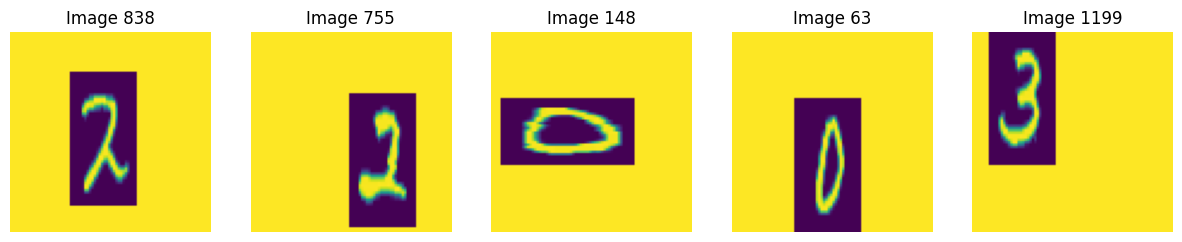

,0
Filepath,0
Top_Left_X,0
Top_Left_Y,0
Width,0
Height,0


In [21]:
# Load the CSV file
df = pd.read_csv(path_csv)


# Select 5 random rows from the dataframe
random_samples = df.sample(n=5)

# Display the random samples
print(random_samples)

# Display the 5 random images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (idx, row) in enumerate(random_samples.iterrows()):
    filepath = os.path.join(image_dir, row['Filepath'])
    image = Image.open(filepath)
    axes[i].imshow(image)
    axes[i].set_title(f"Image {idx}")  # This shows the original index
    axes[i].axis('off')

plt.show()
df.isnull().sum()

In [22]:
df.shape

(3000, 5)


# Exercise: Image Preprocessing and CNN Model Development
## Objective:
In this exercise, you are tasked with developing a Convolutional Neural Network (CNN) model to classify images based on a provided dataset. The images are contained within a larger white background, and their actual dimensions vary between two sizes: 28x56 pixels and 56x28 pixels. Your challenge involves multiple steps, including data preprocessing, dataset creation, and CNN model development.

## Dataset Description:
The dataset is defined in a CSV file named image_positions.csv, which includes the following columns:

- Filepath: The filename of the image, with the label after the "_"
- Top_Left_X: The top-left X-coordinate of the image within the larger background.
- Top_Left_Y: The top-left Y-coordinate of the image within the larger background.
- Width: The width of the actual image.
- Height: The height of the actual image.


Sample is shown above

Images are embedded into a larger white
canvas and need to be cropped to remove the white background and standardized in size for model input.

# Tasks:
## Data Preprocessing:

- Read the CSV file and for each image, crop it according to the specified coordinates and dimensions to remove the white background.
- Standardize the size of the images for the CNN model.
  - Do not resize before cropping!
  
## Dataset Preparation:

- Split your preprocessed images into training and testing datasets. Ensure you have a balanced distribution of classes in both sets.
- Implement data augmentation techniques if necessary to increase the diversity of your training dataset and improve model robustness.

## CNN Model Development:

- Design and implement a CNN model architecture of your choice to classify the images into their respective categories.
 - You can use a pretrained one
- Compile and train your model using the training dataset. Choose an appropriate loss function and optimizer for the classification task.
- Evaluate your model's performance on the testing dataset. Provide insights into its accuracy and potential areas for improvement.
  - For example what class has the lowest accuarcy

In [46]:
from torch.utils.data import Dataset
from PIL import Image
import glob
class mnistdataset(Dataset):
	def __init__(self, dataset_path, split='Training', transform=None):
		self.image_paths = df['Filepath'].values  # Get all image paths
		self.image_dir = os.path.join(dataset_path, "reshaped_mnist")
		encoding_dict = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4, '5': 5, '6': 6, '7': 7, '8':8,'9':9}


		self.labels = [
			encoding_dict[
				image_path.split('_')[-1].split('.')[0]
				]
				for image_path in self.image_paths
				]

		self.transform = transform  # Transformations to apply
		self.df = df # Add this line to store df in the class

	def __len__(self):
		return len(self.image_paths)  # Total number of images

	def __getitem__(self, idx):
		image_path = self.image_paths[idx]  # Get image path
		# Fix: Cast label to int instead of float
		label = int(self.labels[idx])  # Get corresponding label

		# Load image
		# Fix: Use os.path.join to create the full image path
		full_image_path = os.path.join(self.image_dir, image_path)
		image = Image.open(full_image_path)
		# The following lines were incorrectly indented
		top_left_x = self.df.loc[self.df['Filepath'] == image_path, 'Top_Left_X'].iloc[0]
		top_left_y = self.df.loc[self.df['Filepath'] == image_path, 'Top_Left_Y'].iloc[0]
		width = self.df.loc[self.df['Filepath'] == image_path, 'Width'].iloc[0]
		height = self.df.loc[self.df['Filepath'] == image_path, 'Height'].iloc[0]
		# Crop using CSV coordinates
		image = transforms.functional.crop(image, top_left_y, top_left_x, height, width)
		# Apply transformations (if any)
		if self.transform:
			image = self.transform(image)

		return image, label  # Return processed image and its label

> Created by Ali Habibullah:
> [LinkedIn](https://www.linkedin.com/in/ali-habibullah/)

In [47]:
from torchvision import transforms

transformations = transforms.Compose([
    transforms.Resize((28, 56)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Repeat grayscale 3 times to create 3 channels
])

train_dataset = mnistdataset(path, split='Training', transform=transformations)
valid_dataset = mnistdataset(path, split='Validation', transform=transformations)

# make a data loader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)





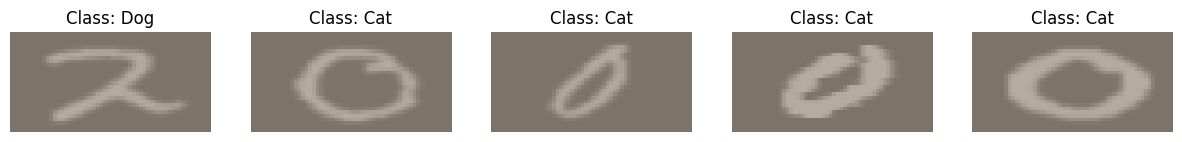

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Define mean & std for denormalization (EfficientNet Preprocessing)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Display 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

imgs_indices = [838,233,110,89,15]

for i in range(5):
    img, label = train_dataset[imgs_indices[i]]  # Load image & label

    # Convert tensor to numpy for visualization
    img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)

    # Denormalize the image
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # Show image
    axes[i].imshow(img_np)
    axes[i].set_title(f'Class: {"Cat" if label == 0 else "Dog"}')
    axes[i].axis('off')

plt.show()

In [54]:
# i used a pretrained efficient net model
from torchvision import models
import torch.nn as nn
import torch

# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)
  # Load pre-trained ResNet-18 model

# Freeze all layers
for param in model.parameters():
	param.requires_grad = False


# Modify the classifier for binary classification (cats vs. dogs)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)  # 2 classes

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)  # The model outputs in shape [batch_size,1]. We convert them to [batch_size,] so the loss accepts them.
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)   # Get predicted class
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # The model outputs in shape [batch_size,1]. We convert them to [batch_size,] so the loss accepts them.
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)
              # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [56]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Fixed: Use CrossEntropyLoss instead of CrossEntropyLossLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Fixed: Use 'model' instead of 'resnet'
num_epochs = 20 # Number of epochs
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")

100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch 1/20: Train Loss=1.7428, Train Accuracy=41.27%, Val Loss=1.3799, Val Accuracy=57.70%


100%|██████████| 94/94 [00:28<00:00,  3.25it/s]


Epoch 2/20: Train Loss=1.2925, Train Accuracy=57.60%, Val Loss=1.0756, Val Accuracy=68.03%


100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Epoch 3/20: Train Loss=1.2059, Train Accuracy=60.47%, Val Loss=0.9735, Val Accuracy=69.80%


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch 4/20: Train Loss=1.1360, Train Accuracy=62.23%, Val Loss=0.9421, Val Accuracy=70.23%


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch 5/20: Train Loss=1.0930, Train Accuracy=63.07%, Val Loss=0.8696, Val Accuracy=73.47%


100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Epoch 6/20: Train Loss=1.0851, Train Accuracy=64.13%, Val Loss=0.8412, Val Accuracy=73.53%


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch 7/20: Train Loss=1.0727, Train Accuracy=65.53%, Val Loss=0.8433, Val Accuracy=73.00%


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch 8/20: Train Loss=1.0569, Train Accuracy=64.33%, Val Loss=0.8067, Val Accuracy=75.13%


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch 9/20: Train Loss=1.0384, Train Accuracy=65.17%, Val Loss=0.7704, Val Accuracy=75.77%


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch 10/20: Train Loss=1.0411, Train Accuracy=65.90%, Val Loss=0.7674, Val Accuracy=75.77%


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch 11/20: Train Loss=1.0262, Train Accuracy=66.47%, Val Loss=0.7906, Val Accuracy=75.30%


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch 12/20: Train Loss=1.0133, Train Accuracy=65.57%, Val Loss=0.7757, Val Accuracy=75.07%


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch 13/20: Train Loss=1.0446, Train Accuracy=64.40%, Val Loss=0.7295, Val Accuracy=77.00%


100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Epoch 14/20: Train Loss=1.0374, Train Accuracy=65.57%, Val Loss=0.7475, Val Accuracy=75.67%


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch 15/20: Train Loss=0.9968, Train Accuracy=65.57%, Val Loss=0.7557, Val Accuracy=75.50%


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch 16/20: Train Loss=1.0178, Train Accuracy=66.47%, Val Loss=0.7289, Val Accuracy=76.27%


100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Epoch 17/20: Train Loss=1.0236, Train Accuracy=66.73%, Val Loss=0.7095, Val Accuracy=76.80%


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch 18/20: Train Loss=1.0238, Train Accuracy=65.60%, Val Loss=0.7049, Val Accuracy=77.17%


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch 19/20: Train Loss=1.0388, Train Accuracy=65.83%, Val Loss=0.7275, Val Accuracy=76.33%


100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


Epoch 20/20: Train Loss=1.0013, Train Accuracy=66.40%, Val Loss=0.7066, Val Accuracy=78.00%


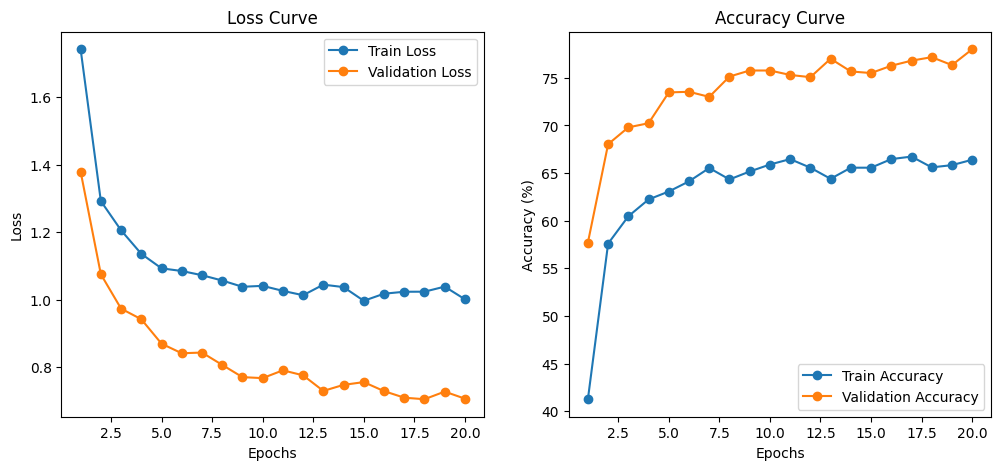

In [57]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()